## Introduction

In [earlier articles we introduced AWS cloud services for data science](/#category=aws), and showed how it can help with different stages of the data science & machine learning workflow.

![](https://github.com/pranath/blog/raw/master/images/aws_ds_workflow.png "The AWS Data Science Workflow")

AWS Sagemaker offers many options for deploying models, in this project we will create an endpoint for a text classification model, splitting the traffic between them. Then after testing and reviewing the endpoint performance metrics, we will shift the traffic to one variant and configure it to autoscale.

## Deployment Options

There are normally 3 main deployment options available for cloud computing services such as AWS.

- **Real-Time Inference:** This involves a continually running process that responds to individual prediction requests on demand
- **Batch Inference:** This involves spinning up computing resources, performing a batch of predictions in one go, then switching off these resources when the process is complete
- **Edge:** This involves optimising a model for running closer to the user on edge devices such as mobile phones to generate predictions there

Real time inference can be useful to respond to requests on demand, such as allowing quick responses to negative customer reviews.

![](https://github.com/pranath/blog/raw/master/images/aws_deploy1.png "Deployment Options")

Batch inference can be useful when time is less critical, for example if we want to indentify a vendor with potential quality issues, we would want to look at a large number of reviews over time.

![](https://github.com/pranath/blog/raw/master/images/aws_deploy2.png "Deployment Options")

Edge deployment can be useful when we want to provide predictions on the device itself, for example when privacy is a concern and we want to keep the data on the users device.

![](https://github.com/pranath/blog/raw/master/images/aws_deploy3.png "Deployment Options")

When should we use each option? this will depend on your use case and a number of factors such as cost and how quickly and where the predictions are needed.

![](https://github.com/pranath/blog/raw/master/images/aws_deploy4.png "Deployment Options")

As a general rule, you should use the option that meets your use case and is the most cost effective.

## Deployment Strategies & Autoscaling

When we deploy models we have 3 key objectives:

- Minimise risk
- Minimise down time
- Measure model performance

There are a range of possible deployment strategies including:

![](https://github.com/pranath/blog/raw/master/images/aws_deploystrat2.png "Deployment Strategies")

In this project we will be using A/B testing.

![](https://github.com/pranath/blog/raw/master/images/aws_deploystrat3.png "Deployment Strategies")

Another interesting strategy thats more dynamic is Multi Armed Bandits which use machine learning to switch between different models dynamically depending on changing performance.

![](https://github.com/pranath/blog/raw/master/images/aws_deploystrat4.png "Deployment Strategies")

But we will be using A/B testing.

We will also be using AWS Sagemaker Hosting to automatically scale our resources depending on demand.

![](https://github.com/pranath/blog/raw/master/images/aws_autoscale2.png "Deployment Strategies")

## Setup

Let's install and import the required modules.

In [ ]:
#| include: false
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!conda install -q -y pytorch==1.6.0 -c pytorch
!pip install --disable-pip-version-check -q transformers==3.5.1

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch==1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.01.10 |       h06a4308_0         120 KB
    certifi-2022.12.7          |   py37h06a4308_0         150 KB
    cudatoolkit-10.2.89        |       hfd86e86_1       365.1 MB
    ninja-1.10.2               |       h06a4308_5           8 KB
    ninja-base-1.10.2          |       hd09550d_5         109 KB
    openssl-1.1.1t             |       h7f8727e_0         3.7 MB
    pytorch-1.6.0              |py3.7_cuda10.2.89_cudnn7.6.5_0       537.7 MB  pytorch
    ------------------------------------------------------------
                                           Total:       906.9 MB

The 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
import boto3
import sagemaker
import pandas as pd
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c3/w2')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

cw = boto3.client(service_name='cloudwatch', 
                  config=config)

autoscale = boto3.client(service_name="application-autoscaling", 
                         config=config)

## Create an endpoint with multiple variants

We have two models trained to analyze customer feedback and classify the messages into positive (1), neutral (0), and negative (-1) sentiments are saved in the following S3 bucket paths. These `tar.gz` files contain the model artifacts, which result from model training.

In [ ]:
model_a_s3_uri = 's3://dlai-practical-data-science/models/ab/variant_a/model.tar.gz'
model_b_s3_uri = 's3://dlai-practical-data-science/models/ab/variant_b/model.tar.gz'

Let's deploy an endpoint splitting the traffic between these two models 50/50 to perform A/B Testing. Instead of creating a PyTorch Model object and calling `model.deploy()` function, we will create an `Endpoint configuration` with multiple model variants. Here is the workflow we will follow to create an endpoint:

![](https://github.com/pranath/blog/raw/master/images/endpoint-workflow.png "Endpoint Workflow")

### Construct Docker Image URI

We will need to create the models in Amazon SageMaker, which retrieves the URI for the pre-built SageMaker Docker image stored in Amazon Elastic Container Re
gistry (ECR). Let's construct the ECR URI which we will pass into the `create_model` function later.

Now lets set the instance type. For the purposes of this project, we will use a relatively small instance. Please refer to [this link](https://aws.amazon.com/sagemaker/pricing/) for additional instance types that may work for your use cases.

In [ ]:
inference_instance_type = 'ml.m5.large'

Let's create an ECR URI using the `'PyTorch'` framework. 

In [ ]:
inference_image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch', 
    version='1.6.0',
    instance_type=inference_instance_type,
    region=region,
    py_version='py3',
    image_scope='inference'
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.6.0-cpu-py3


### Create Amazon SageMaker Models

Amazon SageMaker Model includes information such as the S3 location of the model, the container image that can be used for inference with that model, the execution role, and the model name. 

Let's construct the model names.

In [ ]:
import time
from pprint import pprint

timestamp = int(time.time())

model_name_a = '{}-{}'.format('a', timestamp)
model_name_b = '{}-{}'.format('b', timestamp)

We will use the following function to check if the model already exists in Amazon SageMaker.

In [ ]:
def check_model_existence(model_name):
    for model in sm.list_models()['Models']:
        if model_name == model['ModelName']:
            return True
    return False

Now we shall create an Amazon SageMaker Model based on the `model_a_s3_uri` data.

We will use the `sm.create_model` function, which requires the model name, Amazon SageMaker execution role and a primary container description (`PrimaryContainer` dictionary). The `PrimaryContainer` includes the S3 bucket location of the model artifacts (`ModelDataUrl` key) and ECR URI (`Image` key).

In [ ]:
if not check_model_existence(model_name_a):
    model_a = sm.create_model(
        ModelName=model_name_a,
        ExecutionRoleArn=role,
        PrimaryContainer={
            'ModelDataUrl': model_a_s3_uri,
            'Image': inference_image_uri 
        }
    )
    pprint(model_a)
else:
    print("Model {} already exists".format(model_name_a))

{'ModelArn': 'arn:aws:sagemaker:us-east-1:266291165402:model/a-1677082486',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '74',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 22 Feb 2023 16:15:03 GMT',
                                      'x-amzn-requestid': '8f653536-35b7-40ee-8b7f-de44570c71b9'},
                      'HTTPStatusCode': 200,
                      'RequestId': '8f653536-35b7-40ee-8b7f-de44570c71b9',
                      'RetryAttempts': 0}}


Now lets create an Amazon SageMaker Model based on the `model_b_s3_uri` data.

In [ ]:
if not check_model_existence(model_name_b):
    model_b = sm.create_model(
        ModelName=model_name_b, 
        ExecutionRoleArn=role, 
        PrimaryContainer={
            'ModelDataUrl': model_b_s3_uri, 
            'Image': inference_image_uri
        }
    )
    pprint(model_b)
else:
    print("Model {} already exists".format(model_name_b))

{'ModelArn': 'arn:aws:sagemaker:us-east-1:266291165402:model/b-1677082486',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '74',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 22 Feb 2023 16:15:23 GMT',
                                      'x-amzn-requestid': 'a58a4de2-8ba0-4388-99b8-4f10031c606d'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'a58a4de2-8ba0-4388-99b8-4f10031c606d',
                      'RetryAttempts': 0}}


### Set up Amazon SageMaker production variants

A production variant is a packaged SageMaker Model combined with the configuration related to how that model will be hosted. 

We have constructed the model in the section above. The hosting resources configuration includes information on how we want that model to be hosted: the number and type of instances, a pointer to the SageMaker package model, as well as a variant name and variant weight. A single SageMaker Endpoint can actually include multiple production variants.

Let's create an Amazon SageMaker production variant for the SageMaker Model with the `model_name_a`.

In [ ]:
from sagemaker.session import production_variant

variantA = production_variant(
    model_name=model_name_a, 
    instance_type=inference_instance_type, 
    initial_weight=50,
    initial_instance_count=1,
    variant_name='VariantA',
)
print(variantA)

{'ModelName': 'a-1677082486', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantA', 'InitialVariantWeight': 50}


Now lets create an Amazon SageMaker production variant for the SageMaker Model with the `model_name_b`.

In [ ]:
variantB = production_variant(
    model_name=model_name_b, 
    instance_type=inference_instance_type, 
    initial_weight=50, 
    initial_instance_count=1,
    variant_name='VariantB'
)
print(variantB)

{'ModelName': 'b-1677082486', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantB', 'InitialVariantWeight': 50}


### Configure and create the endpoint

We will use the following functions to check if the endpoint configuration and endpoint itself already exist in Amazon SageMaker.

In [ ]:
def check_endpoint_config_existence(endpoint_config_name):
    for endpoint_config in sm.list_endpoint_configs()['EndpointConfigs']:
        if endpoint_config_name == endpoint_config['EndpointConfigName']:
            return True
    return False

def check_endpoint_existence(endpoint_name):
    for endpoint in sm.list_endpoints()['Endpoints']:
        if endpoint_name == endpoint['EndpointName']:
            return True
    return False

We create the endpoint configuration by specifying the name and pointing to the two production variants that we just configured that tell SageMaker how we want to host those models.

In [ ]:
endpoint_config_name = '{}-{}'.format('ab', timestamp)

if not check_endpoint_config_existence(endpoint_config_name):
    endpoint_config = sm.create_endpoint_config(
        EndpointConfigName=endpoint_config_name, 
        ProductionVariants=[variantA, variantB]
    )
    pprint(endpoint_config)
else:
    print("Endpoint configuration {} already exists".format(endpoint_config_name))

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:266291165402:endpoint-config/ab-1677082486',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '94',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 22 Feb 2023 16:16:04 GMT',
                                      'x-amzn-requestid': 'caa4197d-8d8a-4b0e-ab55-e20d5bfe31d6'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'caa4197d-8d8a-4b0e-ab55-e20d5bfe31d6',
                      'RetryAttempts': 0}}


Construct the endpoint name.

In [ ]:
model_ab_endpoint_name = '{}-{}'.format('ab', timestamp)
print('Endpoint name: {}'.format(model_ab_endpoint_name))

Endpoint name: ab-1677082486


Lets create an endpoint with the endpoint name and configuration defined above.

In [ ]:
if not check_endpoint_existence(model_ab_endpoint_name):
    endpoint_response = sm.create_endpoint(
        EndpointName=model_ab_endpoint_name, 
        EndpointConfigName=endpoint_config_name
    )
    print('Creating endpoint {}'.format(model_ab_endpoint_name))
    pprint(endpoint_response)
else:
    print("Endpoint {} already exists".format(model_ab_endpoint_name))

Creating endpoint ab-1677082486
{'EndpointArn': 'arn:aws:sagemaker:us-east-1:266291165402:endpoint/ab-1677082486',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '81',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 22 Feb 2023 16:16:24 GMT',
                                      'x-amzn-requestid': '0d5dd2d5-519a-4618-ab29-809c0e3e28da'},
                      'HTTPStatusCode': 200,
                      'RequestId': '0d5dd2d5-519a-4618-ab29-809c0e3e28da',
                      'RetryAttempts': 0}}


Now we wait for the endpoint to deploy.

In [ ]:
%%time

waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_ab_endpoint_name)

CPU times: user 133 ms, sys: 21 ms, total: 154 ms
Wall time: 5min 1s


## Test model

### Test the model on a few sample strings

Here, we will pass sample strings of text to the endpoint in order to see the sentiment. We give one example of each.

Now we create an Amazon SageMaker Predictor based on the deployed endpoint.

We will use the `Predictor` object with the following parameters. We pass JSON serializer and deserializer objects here, calling them with the functions `JSONLinesSerializer()` and `JSONLinesDeserializer()`, respectively. More information about the serializers can be found [here](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html).

In [ ]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = Predictor(
    endpoint_name=model_ab_endpoint_name, 
    serializer=JSONLinesSerializer(), 
    deserializer=JSONLinesDeserializer(), 
    sagemaker_session=sess
)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

Predicted class 1 with probability 0.9605445861816406
Predicted class 0 with probability 0.5798221230506897
Predicted class -1 with probability 0.7667604684829712


### Generate traffic and review the endpoint performance metrics

Now we will generate some traffic. To analyze the endpoint performance we will review some of the metrics that Amazon SageMaker emits in CloudWatch: CPU Utilization, Latency and Invocations. 

A full list of namespaces and metrics can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html). CloudWatch `get_metric_statistics` documentation can be found [here](https://docs.aws.amazon.com/AmazonCloudWatch/latest/APIReference/API_GetMetricStatistics.html).

But before that, let's create a function that will help to extract the results from CloudWatch and plot them.

In [ ]:
def plot_endpoint_metrics_for_variants(endpoint_name, 
                                       namespace_name, 
                                       metric_name, 
                                       variant_names, 
                                       start_time, 
                                       end_time):
    
    try:
        joint_variant_metrics = None

        for variant_name in variant_names:
            metrics = cw.get_metric_statistics( # extracts the results in a dictionary format
                Namespace=namespace_name, # the namespace of the metric, e.g. "AWS/SageMaker"
                MetricName=metric_name, # the name of the metric, e.g. "CPUUtilization"
                StartTime=start_time, # the time stamp that determines the first data point to return
                EndTime=end_time, # the time stamp that determines the last data point to return
                Period=60, # the granularity, in seconds, of the returned data points
                Statistics=["Sum"], # the metric statistics
                Dimensions=[ # dimensions, as CloudWatch treats each unique combination of dimensions as a separate metric
                    {"Name": "EndpointName", "Value": endpoint_name}, 
                    {"Name": "VariantName", "Value": variant_name}
                ],
            )
            
            if metrics["Datapoints"]: # access the results from the distionary using the key "Datapoints"
                df_metrics = pd.DataFrame(metrics["Datapoints"]) \
                    .sort_values("Timestamp") \
                    .set_index("Timestamp") \
                    .drop("Unit", axis=1) \
                    .rename(columns={"Sum": variant_name}) # rename the column with the metric results as a variant_name
                
                if joint_variant_metrics is None:
                    joint_variant_metrics = df_metrics
                else:
                    joint_variant_metrics = joint_variant_metrics.join(df_metrics, how="outer")
        
        joint_variant_metrics.plot(title=metric_name)
    except:
        pass

We must establish wide enough time bounds to show all the charts using the same timeframe:

In [ ]:
from datetime import datetime, timedelta

start_time = datetime.now() - timedelta(minutes=30)
end_time = datetime.now() + timedelta(minutes=30)

print('Start Time: {}'.format(start_time))
print('End Time: {}'.format(end_time))

Start Time: 2023-02-22 15:52:19.078234
End Time: 2023-02-22 16:52:19.078289


Set the list of the the variant names to analyze.

In [ ]:
variant_names = [variantA["VariantName"], variantB["VariantName"]]

print(variant_names)

['VariantA', 'VariantB']


Now run some predictions and view the metrics for each variant.

In [ ]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 239 ms, sys: 4.17 ms, total: 243 ms
Wall time: 1min 28s


Let’s query CloudWatch to get a few metrics that are split across variants.

In [ ]:
time.sleep(30) # Sleep to accomodate a slight delay in metrics gathering

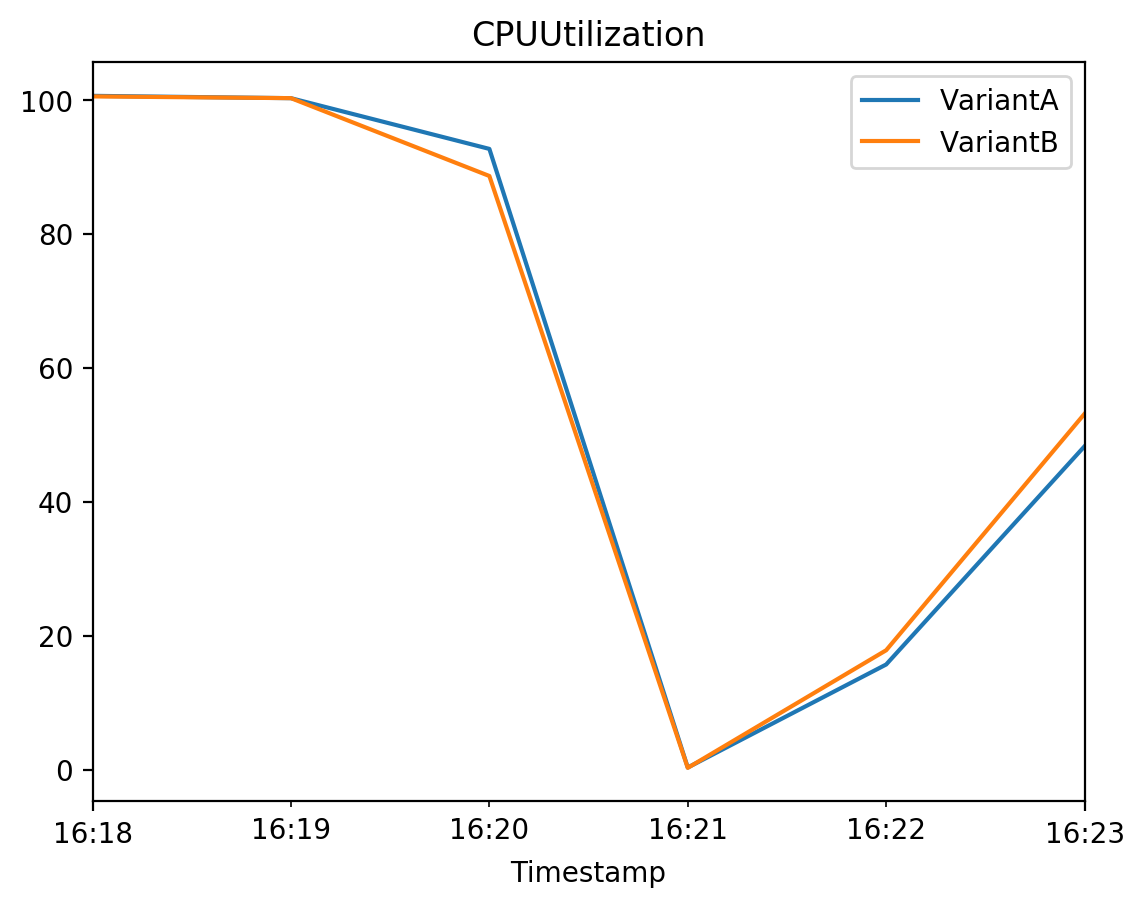

In [ ]:
# CPUUtilization
# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints", 
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

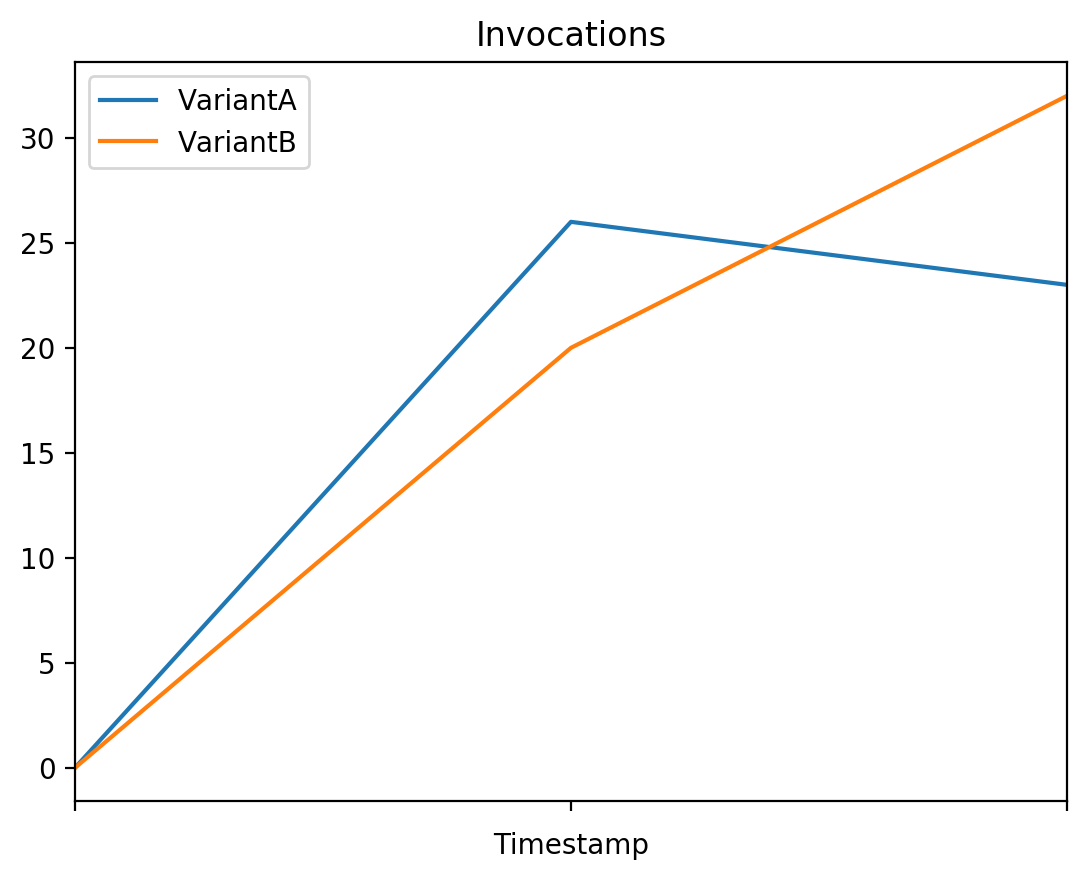

In [ ]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

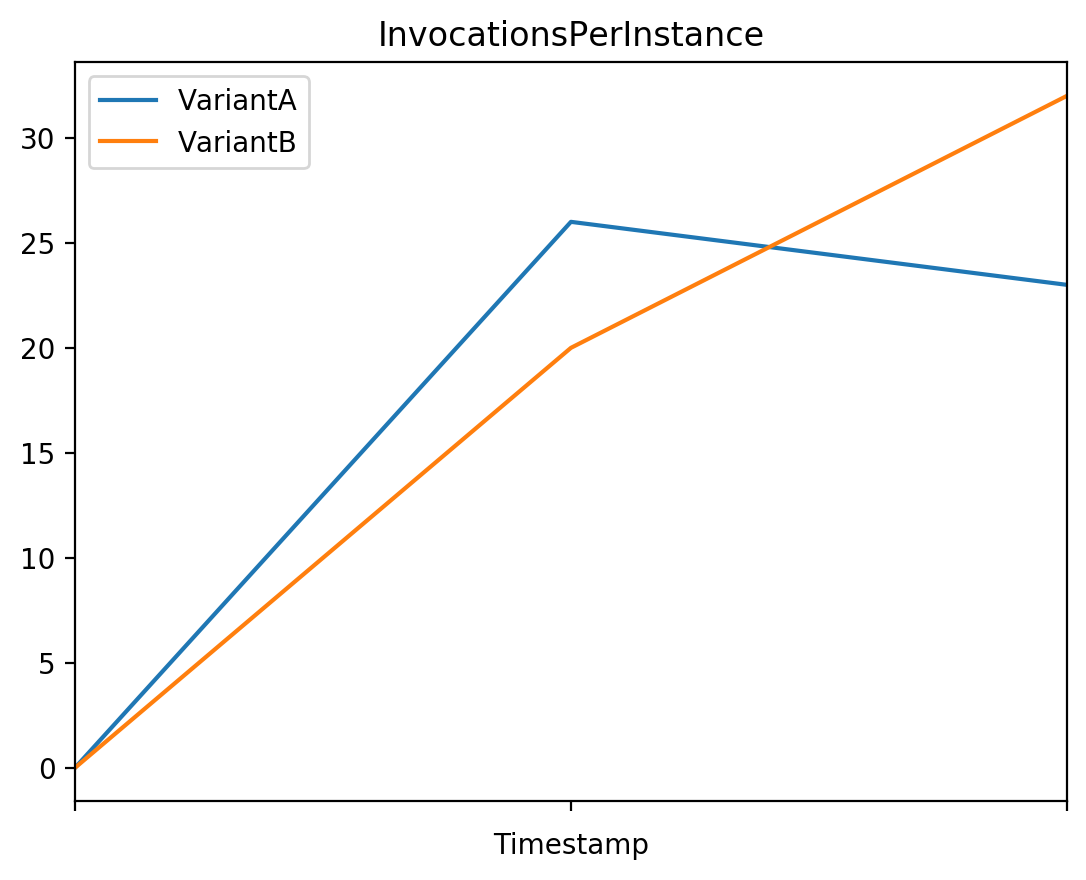

In [ ]:
# InvocationsPerInstance
# The number of invocations sent to a model, normalized by InstanceCount in each production variant.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="InvocationsPerInstance",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

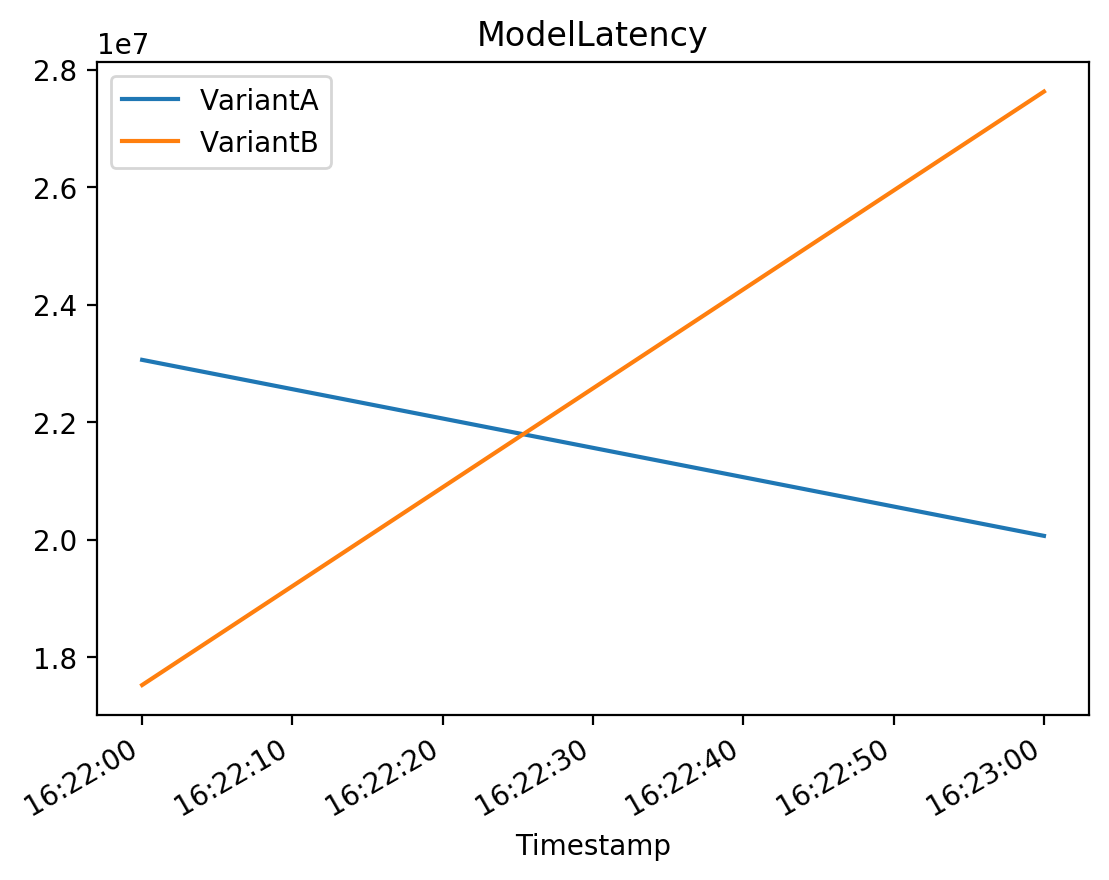

In [ ]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

## Shift the traffic to one variant and review the endpoint performance metrics

Generally, the winning model would need to be chosen. The decision would be made based on the endpoint performance metrics and some other business related evaluations. Here we will assume that the winning model is in the Variant B and shift all traffic to it. 

Let's now construct a list with the updated endpoint weights.

In [ ]:
updated_endpoint_config = [
    {
        "VariantName": variantA["VariantName"],
        "DesiredWeight": 0,
    },
    {
        "VariantName": variantB["VariantName"],
        "DesiredWeight": 100,
    },
]

Now we update variant weights in the configuration of the existing endpoint.

We will use the `sm.update_endpoint_weights_and_capacities` function, passing the endpoint name and list of updated weights for each of the variants that we defined above.

In [ ]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=model_ab_endpoint_name, 
    DesiredWeightsAndCapacities=updated_endpoint_config 
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:266291165402:endpoint/ab-1677082486',
 'ResponseMetadata': {'RequestId': 'd150d0c7-90d9-48bd-b9fd-06aed5f7c4b7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd150d0c7-90d9-48bd-b9fd-06aed5f7c4b7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Wed, 22 Feb 2023 16:24:19 GMT'},
  'RetryAttempts': 0}}

In [ ]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

Now run some more predictions and view the metrics for each variant.

In [ ]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 256 ms, sys: 3.23 ms, total: 259 ms
Wall time: 1min 27s


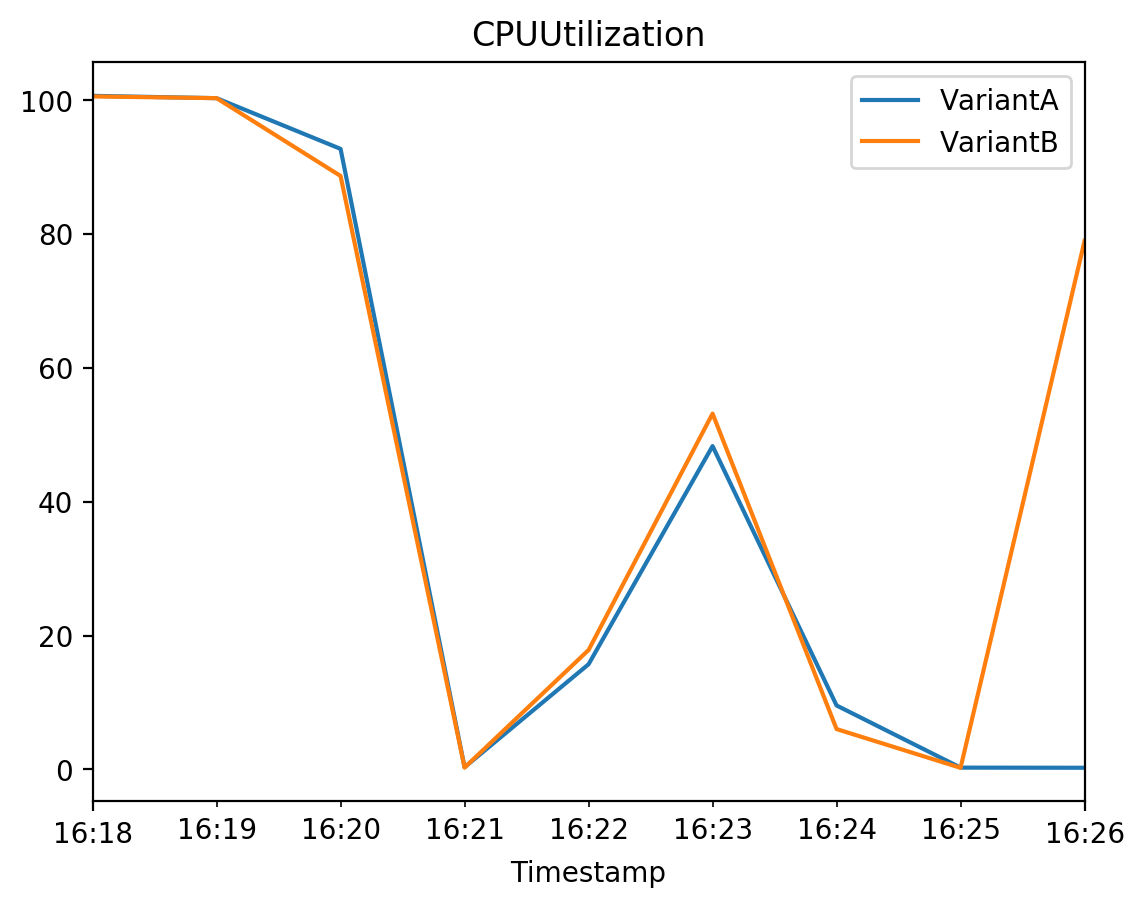

In [ ]:
# CPUUtilization
# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints",
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

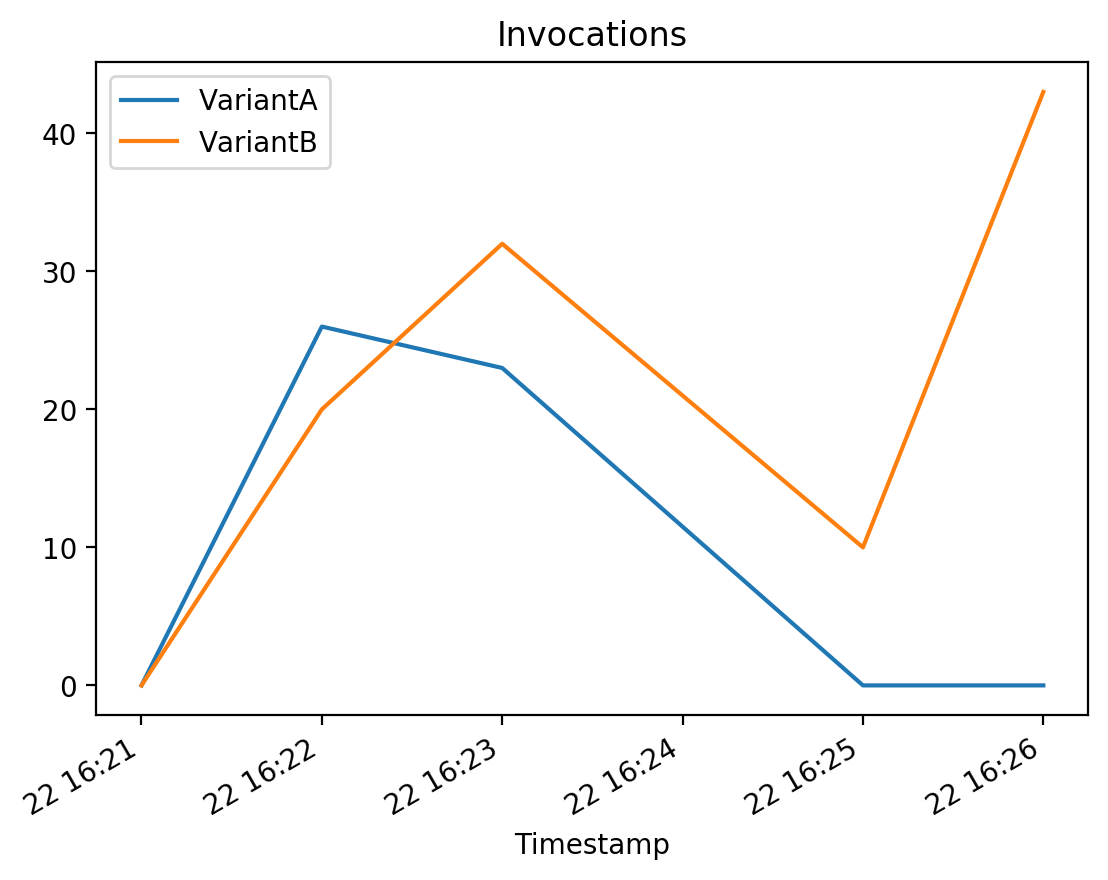

In [ ]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

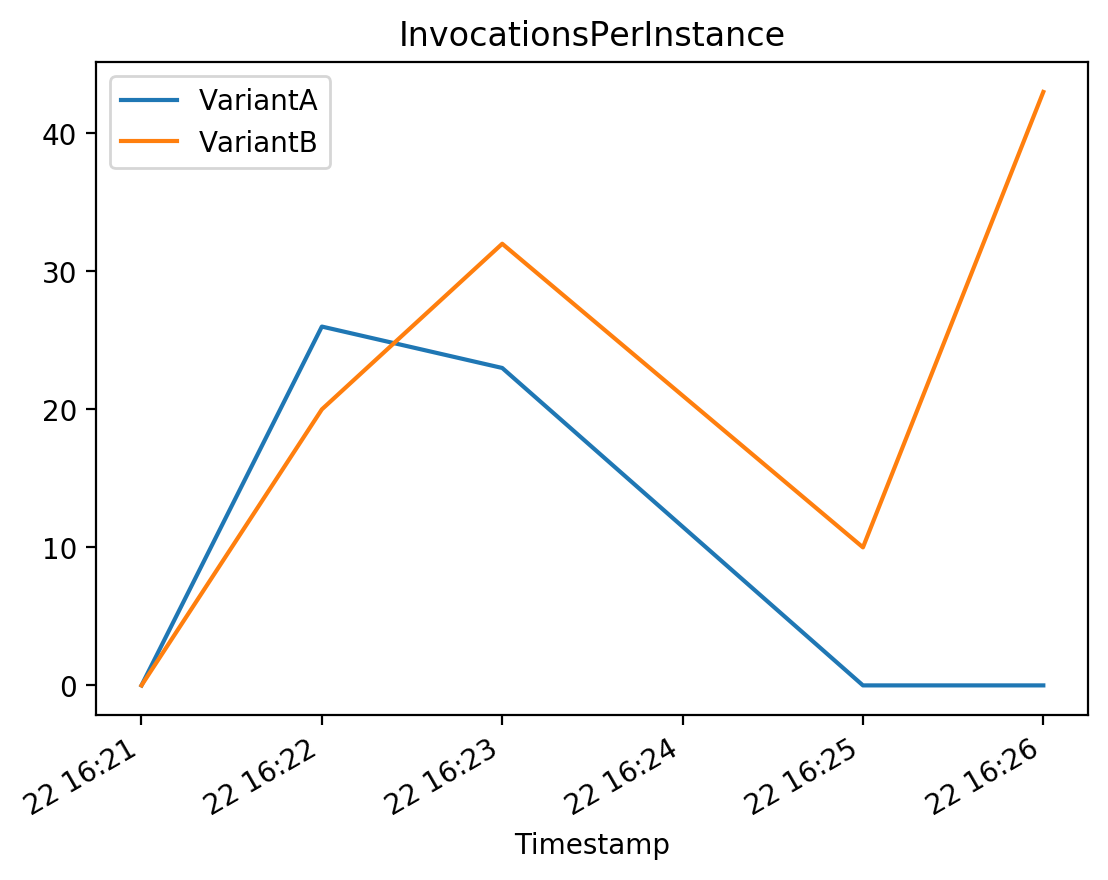

In [ ]:
# InvocationsPerInstance
# The number of invocations sent to a model, normalized by InstanceCount in each production variant.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="InvocationsPerInstance",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

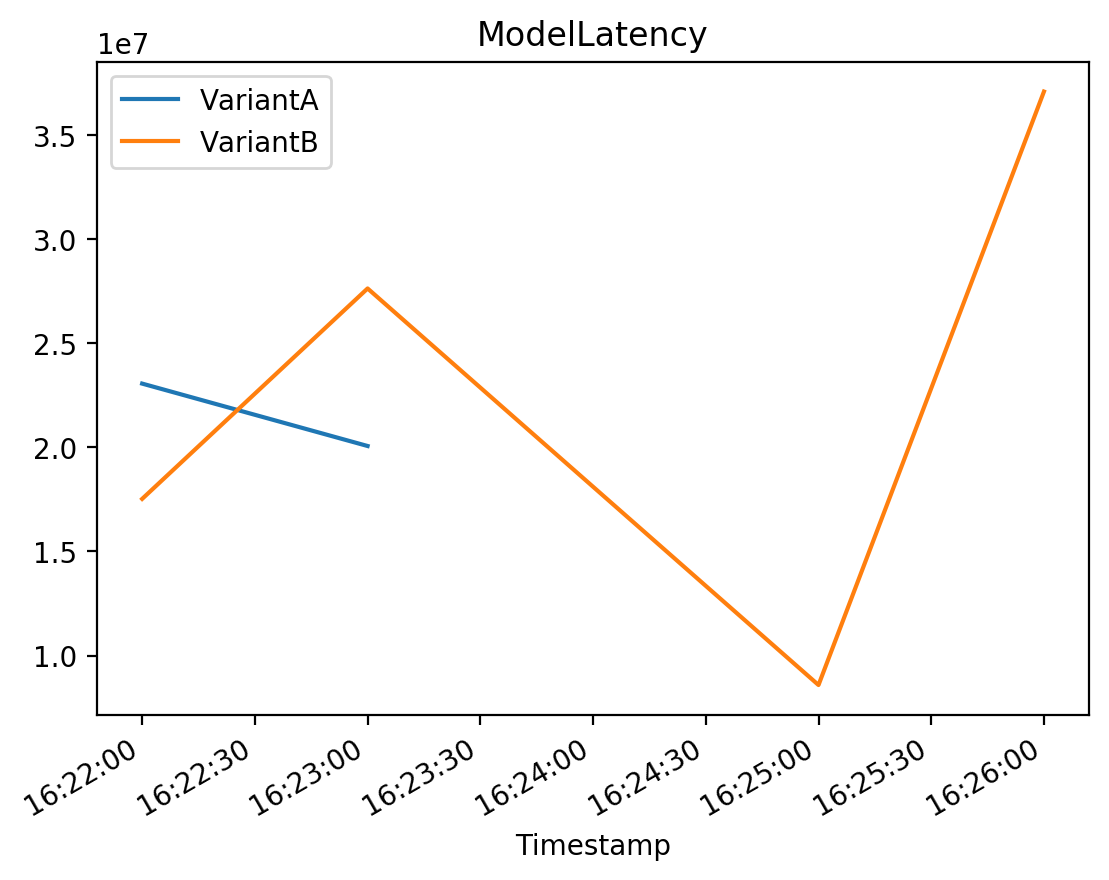

In [ ]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

## Configure one variant to autoscale

Let's configure Variant B to autoscale. We would not autoscale Variant A since no traffic is being passed to it at this time.

First, we need to define a scalable target. It is an AWS resource and in this case you want to scale a `sagemaker` resource as indicated in the `ServiceNameSpace` parameter. Then the `ResourceId` is a SageMaker Endpoint. Because autoscaling is used by other AWS resources, we’ll see a few parameters that will remain static for scaling SageMaker Endpoints. Thus the `ScalableDimension` is a set value for SageMaker Endpoint scaling.

We also need to specify a few key parameters that control the min and max behavior for our Machine Learning instances. The `MinCapacity` indicates the minimum number of instances we plan to scale in to. The `MaxCapacity` is the maximum number of instances we want to scale out to. So in this case we always want to have at least 1 instance running and a maximum of 2 during peak periods. 

In [ ]:
autoscale.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=2,
    RoleARN=role,
    SuspendedState={
        "DynamicScalingInSuspended": False,
        "DynamicScalingOutSuspended": False,
        "ScheduledScalingSuspended": False,
    },
)

{'ResponseMetadata': {'RequestId': '1df51ac9-60ae-4b21-9c3a-2b676e32802c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1df51ac9-60ae-4b21-9c3a-2b676e32802c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Wed, 22 Feb 2023 16:27:20 GMT'},
  'RetryAttempts': 0}}

In [ ]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

Check that the parameters from the function above are in the description of the scalable target:

In [ ]:
autoscale.describe_scalable_targets(
    ServiceNamespace="sagemaker",
    MaxResults=100,
)

{'ScalableTargets': [{'ServiceNamespace': 'sagemaker',
   'ResourceId': 'endpoint/ab-1677082486/variant/VariantB',
   'ScalableDimension': 'sagemaker:variant:DesiredInstanceCount',
   'MinCapacity': 1,
   'MaxCapacity': 2,
   'RoleARN': 'arn:aws:iam::266291165402:role/aws-service-role/sagemaker.application-autoscaling.amazonaws.com/AWSServiceRoleForApplicationAutoScaling_SageMakerEndpoint',
   'CreationTime': datetime.datetime(2023, 2, 22, 16, 27, 20, 908000, tzinfo=tzlocal()),
   'SuspendedState': {'DynamicScalingInSuspended': False,
    'DynamicScalingOutSuspended': False,
    'ScheduledScalingSuspended': False}}],
 'ResponseMetadata': {'RequestId': 'bd518cbf-fc90-40e5-9d45-56f2252dfe71',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bd518cbf-fc90-40e5-9d45-56f2252dfe71',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '522',
   'date': 'Wed, 22 Feb 2023 16:27:20 GMT'},
  'RetryAttempts': 0}}

Define and apply scaling policy using the `put_scaling_policy` function. The scaling policy provides additional information about the scaling behavior for our instance. `TargetTrackingScaling` refers to a specific autoscaling type supported by SageMaker, that uses a scaling metric and a target value as the indicator to scale.

In the scaling policy configuration, we have the predefined metric `PredefinedMetricSpecification` which is the number of invocations on our instance and the `TargetValue` which indicates the number of invocations per ML instance we want to allow before triggering your scaling policy. A scale out cooldown of 60 seconds means that after autoscaling successfully scales out it starts to calculate the cooldown time. The scaling policy won’t increase the desired capacity again until the cooldown period ends.

The scale in cooldown setting of 300 seconds means that SageMaker will not attempt to start another cooldown policy within 300 seconds of when the last one completed.

In [ ]:
autoscale.put_scaling_policy(
    PolicyName="bert-reviews-autoscale-policy",
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 2.0, # the number of invocations per ML instance you want to allow before triggering your scaling policy
        "PredefinedMetricSpecification": {
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance", # scaling metric
        },
        "ScaleOutCooldown": 60, # wait time, in seconds, before beginning another scale out activity after last one completes
        "ScaleInCooldown": 300, # wait time, in seconds, before beginning another scale in activity after last one completes
    },
)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:266291165402:scalingPolicy:913d3148-a6ef-4773-a62f-44892892074e:resource/sagemaker/endpoint/ab-1677082486/variant/VariantB:policyName/bert-reviews-autoscale-policy',
 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/ab-1677082486/variant/VariantB-AlarmHigh-c3f6ea38-0824-48ec-b42f-dbacfbe50cc4',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:266291165402:alarm:TargetTracking-endpoint/ab-1677082486/variant/VariantB-AlarmHigh-c3f6ea38-0824-48ec-b42f-dbacfbe50cc4'},
  {'AlarmName': 'TargetTracking-endpoint/ab-1677082486/variant/VariantB-AlarmLow-15074d95-12ab-446d-8ebe-b17964112be7',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:266291165402:alarm:TargetTracking-endpoint/ab-1677082486/variant/VariantB-AlarmLow-15074d95-12ab-446d-8ebe-b17964112be7'}],
 'ResponseMetadata': {'RequestId': 'c82eb21e-613e-4143-a40c-3a852ac5b1e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c82eb21e-613e-4143-a40c-3a852ac5b1e8',
   'content-type': 'ap

In [ ]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

## Acknowledgements

I'd like to express my thanks to the great [Deep Learning AI Practical Data Science on AWS Specialisation Course](https://www.deeplearning.ai/courses/practical-data-science-specialization/) which i completed, and acknowledge the use of some images and other materials from the training course in this article.